# Modifying the environment

In order to use RL and Dynamic programming, the agent needs to know its state.
In the general case, it needs to estimate its state, however for the first part of the lecture we will simply provide the state to the agent.

In the case of the Dungeon environment, the state of the agent is entirely described by either the coordinates of the cell it is on, or the index of the cell.

The first task is to modify the environment so that we can get all the necessary information:
- the value function (can be represented as a dictionary, or an array) that maps the state to the value of the state. As we don't know the true value at the beginning, it will be initialized at 1.
- the transition matrix, which maps the state and actions to new states
- the reward matrix, which maps the state and action to rewards


In [301]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import namedtuple

Action = namedtuple('Action','name index delta_i delta_j')

up = Action('up', 0, -1, 0)
down = Action('down', 1,1, 0)
left = Action('left', 2, 0, -1)
right = Action('right', 3,0,1)

index_to_actions = {}

for action in [up, down, left, right]:
    index_to_actions[action.index] = action

In [302]:
class Dungeon:
    
    def __init__(self, N):
        
        # Numpy array that holds the information about the environment
        self.dungeon = np.zeros([int(N),int(N)])
        self.N = N
        self.size = N
        # position of the agent and exit will be decided by resetting the environment.
        self.position_agent = None
        self.position_exit = None
        #position of obstacles randomly generated. Create an array with 5 rows and 2 columns to represent the coordinates of each obstacle
        self.position_obstacles = np.random.randint(1,self.N-1, size=(self.N//2, 2))
        for x,y in enumerate(self.position_obstacles):
          self.dungeon[y[0]][y[1]] = 1
        
        self.dungeon[0,:] = 1
        self.dungeon[N-1,:] = 1
        self.dungeon[:, 0] = 1
        self.dungeon[:, N-1] = 1

        #position of lava randomly generated. Create an array with 5 rows and 2 columns to represent the coordinates of lava. These should have no overlap with obstacles. These 2 arrays will be used to add relevant numbers to dungeon array
        self.position_lava = np.random.randint(1,self.N-1, size=(self.N//2, 2))
        for x,y in enumerate(self.position_lava):
          self.dungeon[y[0]][y[1]] = 2
        
         # position of the exit is a numpy array

        self.position_exit = np.random.randint(1,self.N-1, size=(2, 1))
        self.dungeon[self.position_exit[0],self.position_exit[1]] = 3

        # run time
        self.time_elapsed = 0
        self.time_limit = self.N**2
        
        reward = 0


    def step(self, action):
        
        # action is 'up', 'down', 'left', or 'right'
        if action == 'up': 
          action = np.array([[-1],[0]])
        elif action == 'down':
          action = np.array([[1],[0]])
        elif action == 'left':
          action = np.array([[0],[-1]])
        elif action == 'right':
          action = np.array([[0],[1]])

        # modify the position of the agent. Add the movement array to the position of the agent. if the cell it moves to is obstacle, don't allow movement and -5 from reward. If lava then just -20 from reward but allow movement. If at exit then +N**2 to reward.

        #print(self.position_agent)
        #print(action)

        position_agent_new = (self.position_agent + action)
        global reward
        if self.time_elapsed == 0:
          reward = 0
        if self.dungeon[position_agent_new[0], [position_agent_new[1]]] == 1: 
          position_agent_new = self.position_agent
          r = -5
        elif self.dungeon[position_agent_new[0], [position_agent_new[1]]] == 2:
          self.position_agent = position_agent_new 
          r = -20
        elif self.dungeon[position_agent_new[0], [position_agent_new[1]]] == 3:
          self.position_agent = position_agent_new 
          r = +self.N**2
        else: 
          self.position_agent = position_agent_new 
          r = 0




        # calculate total reward. -1 each time for time-step

        reward = reward + r -1
        #print(reward)

        # calculate observations. Need to create a dictionary containing the target coordinates (position_exit) and the surrounding 12 cells with agent central (will probably have to slice the dungeon array)

        #observations = self.dungeon
        #observations[self.position_agent[0], self.position_agent[1]] = 5
        xmin = int((self.position_agent[0])-1)
        xmax = int((self.position_agent[0])+2)
        ymin = int((self.position_agent[1])-1)
        ymax = int(self.position_agent[1]+2)
        #print('xmax=', xmax)
        #print('xmin=', xmin)
        #print('ymax', ymax)
        #print('ymin', ymin)
        #self.dungeon[self.position_agent[0],self.position_agent[1]] = 5
        pov = self.dungeon[xmin:xmax,ymin:ymax]
        observations = {'target': self.position_exit-self.position_agent, 'proximity': pov}
        #print(observations)

        # add time step
        self.time_elapsed = self.time_elapsed+1
        
        # verify termination condition
        if self.dungeon[self.position_agent[0],self.position_agent[1]] == 3:
          done = 1
        elif self.time_elapsed == self.time_limit:
          done = 1
        else: 
          done = 0
        
        return observations, reward, done
    



    def display(self):
        
        print(self.dungeon)
        
        



    def reset(self):
        """
        This function resets the environment to its original state (time = 0).
        Then it places the agent and exit at new random locations.
        
        It is common practice to return the observations, 
        so that the agent can decide on the first action right after the resetting of the environment.
        
        """

        self.time_elapsed = 0
        reward = 0
        # position of the agent is a numpy array

        self.position_agent = np.random.randint(1,self.N-1, size=(2, 1))
        
        # position of the exit is a numpy array

        #self.position_exit = np.random.randint(1,self.N-1, size=(2, 1))
        #self.dungeon[self.position_exit[0],self.position_exit[1]] = 3


        # Calculate observations
        xmin = int((self.position_agent[0])-1)
        xmax = int((self.position_agent[0])+2)
        ymin = int((self.position_agent[1])-1)
        ymax = int(self.position_agent[1]+2)
        #print('xmax=', xmax)
        #print('xmin=', xmin)
        #print('ymax', ymax)
        #print('ymin', ymin)
        self.dungeon[self.position_agent[0],self.position_agent[1]] = 5
        tar = self.position_exit-self.position_agent
        pov = self.dungeon[xmin:xmax,ymin:ymax]
        observations = {'target': tar, 'proximity': pov}
        #print(observations)
        #observations[self.position_exit[0],self.position_exit[1]] = 2

        return observations

In [303]:
class DungeonDP(Dungeon):
    
    def __init__(self, N):
        
        super().__init__(N)
        # Additional calculations to get the transition and reward matrix
        self.reward_matrix = -1 * np.ones((N*N, 4)) # All movements give you by default a reward of -1
        self.transition_matrix = np.zeros((N*N, 4, N*N))
        
        # In order to explicitely show that the way you represent states doesn't matter, 
        # we will assign a random index for each coordinate of the grid        
        index_states = np.arange(0, N*N)
        np.random.shuffle(index_states)
        self.coord_to_index_state = index_states.reshape(N,N)
        
        # fill the matrix with appropriate values
        # What happens for cells corresponding to obstacles? what should they transition to?
        for i in range(1, N-1):
            for j in range(1, N-1):
                
                current_state = self.coord_to_index_state[i,j]
                current_cell = self.dungeon[i,j]
                
                for action in [up, down, left, right]:
                    destination_cell = self.dungeon[i + action.delta_i , j + action.delta_j]
                    next_state = self.coord_to_index_state[i + action.delta_i, j + action.delta_j]

                    # Check if you bump
                    if destination_cell in [0, 2, 3]:    
                        self.transition_matrix[current_state, action.index, next_state] = 1
                    else:
                        self.transition_matrix[current_state, action.index, current_state] = 1
                        destination_cell = current_cell
                        next_state = current_state
                        self.reward_matrix[current_state, action.index] += -5 

                    # Check where the agent ends up
                    if destination_cell == 2:
                        self.reward_matrix[current_state, action.index] += -20

                    if destination_cell == 3:
                        self.reward_matrix[current_state, action.index] += self.N**2
                        
                        
    def print_reward_matrices(self):
        
        for action in [up, down, left, right]:
            
#             reward_matrix = self.reward_matrix[:,action.index].reshape(self.size, self.size)

            reward_matrix = np.zeros( (self.size, self.size) )
    
            for i in range(1, self.size-1):
                    for j in range(1, self.size-1):

                        state = self.coord_to_index_state[i, j]
                        reward_matrix[i,j] = self.reward_matrix[state, action.index]
                        
            print( action.name)
            print(reward_matrix)
            
        
    def step(self, action):
        
        obs, rew, done = super().step(action)
        
        state = int(self.coord_to_index_state[self.position_agent[0], self.position_agent[1]])
        
        return state, rew, done
    
    def reset(self):
        
        super().reset()
        
        state = int(self.coord_to_index_state[ self.position_agent[0], self.position_agent[1]])
        
        return state

        

In [304]:
dun = DungeonDP(5)
state = dun.reset()
dun.display()
print(state)

[[1. 1. 1. 1. 1.]
 [1. 3. 0. 1. 1.]
 [1. 1. 2. 0. 1.]
 [1. 5. 2. 0. 1.]
 [1. 1. 1. 1. 1.]]
14


In [305]:
dun.print_reward_matrices()

#state, rew, dont = dun.step('down')
#state = dun.reset
print(state)

up
[[  0.   0.   0.   0.   0.]
 [  0.  19.  -6.  -6.   0.]
 [  0.  24.  -1.  -6.   0.]
 [  0.  -6. -21.  -1.   0.]
 [  0.   0.   0.   0.   0.]]
down
[[  0.   0.   0.   0.   0.]
 [  0.  19. -21.  -1.   0.]
 [  0.  -1. -21.  -1.   0.]
 [  0.  -6. -26.  -6.   0.]
 [  0.   0.   0.   0.   0.]]
left
[[  0.   0.   0.   0.   0.]
 [  0.  19.  24.  -1.   0.]
 [  0.  -6. -26. -21.   0.]
 [  0.  -6.  -1. -21.   0.]
 [  0.   0.   0.   0.   0.]]
right
[[  0.   0.   0.   0.   0.]
 [  0.  -1.  -6.  -6.   0.]
 [  0. -21.  -1.  -6.   0.]
 [  0. -21.  -1.  -6.   0.]
 [  0.   0.   0.   0.   0.]]
14


# Policy Evaluation

We will choose a random policy as initial policy.

Created a class Policy which is initialized as a random policy. (Each action can be picked with a probability of 0.25 for every state).

When calling the instance of a Policy, with a state as argument, selected action is returned. 

We will also implement a method for policy evaluation, and a method for policy improvement.


In [306]:
class Policy():
    
    def __init__(self, environment, gamma):
        
        # Get relevant info from environment
        self.size_environment = environment.size
        self.transition_matrix = environment.transition_matrix
        self.reward_matrix = environment.reward_matrix
        self.coord_to_index_state = environment.coord_to_index_state
        
        self.size_state_space = self.size_environment**2
        self.coord_to_index_state = environment.coord_to_index_state
        
        # the policy is a numpy array that collects all the probabilities of chosing an action when in a state
        self.probability_actions = np.ones((self.size_state_space, 4))*0.25        
        
        # We initialize the values to 0
        self.values = np.zeros( self.size_state_space )
        
        # Discount factor
        self.gamma = gamma
        
    def __call__(self, state):
        # Sample an action from the policy, given a state
        
        proba_of_action = self.probability_actions[state]

        index_action = np.argmax(np.random.multinomial(1, proba_of_action ))
        
        return index_to_actions[index_action].name
        
    def iterative_policy_evaluation( self, n_iterations):
    
        # restart from initial values
        # we could restart also from random values, or from our previous estimate of values
        
        self.values = np.zeros( self.size_state_space )        

        # We update the values using the bellman equation
        for iteration in range(n_iterations):
            self.values = np.sum(self.probability_actions * 
                                 (self.reward_matrix 
                                  + self.gamma * np.dot(self.transition_matrix, self.values) 
                                 ), axis = 1) 
    
    def display_values(self):
        
        value_matrix = np.zeros( (self.size_environment, self.size_environment) )
    
    
        for i in range(self.size_environment):
            for j in range(self.size_environment):

                state = self.coord_to_index_state[i, j]
                
                value_matrix[i,j] = self.values[state]
                
        return value_matrix
                                        
    def greedy_improvement(self):
    
        argmax_actions = np.argmax( self.reward_matrix + self.gamma * np.dot(self.transition_matrix, self.values), axis = 1)
    
        # Filter only actions which are possible
        for index_state in range(self.size_state_space):
            
            best_action_index = argmax_actions[index_state]
            
            if self.transition_matrix[index_state][best_action_index].sum() != 0:
                
                self.probability_actions[index_state,:] = 0
                self.probability_actions[index_state, best_action_index] = 1
    
    def policy_iteration(self, n_evaluations):
        
        self.iterative_policy_evaluation(n_evaluations)
        self.greedy_improvement()

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 1. 2. 3. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 2. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [1. 0. 1. 1. 0. 2. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 2. 0. 1.]
 [1. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [1. 0. 0. 5. 0. 0. 0. 0. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


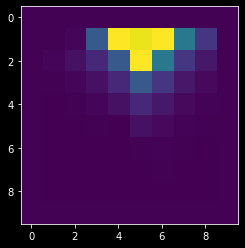

[[-1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  -1.00000000e+00 -1.00000000e+00]
 [-1.00000000e+00 -5.22561024e-01  1.21823898e+00  4.36502390e+01
   1.61650239e+02  1.56650239e+02  1.61650239e+02  6.36502390e+01
   2.44502390e+01 -1.00000000e+00]
 [-1.00000000e+00  1.21823898e+00  5.57023898e+00  1.64502390e+01
   4.36502390e+01  1.61650239e+02  6.36502390e+01  2.44502390e+01
   8.77023898e+00 -1.00000000e+00]
 [-1.00000000e+00 -5.22561024e-01  1.21823898e+00  5.57023898e+00
   1.64502390e+01  4.36502390e+01  2.44502390e+01  8.77023898e+00
   2.49823898e+00 -1.00000000e+00]
 [-1.00000000e+00 -1.21888102e+00 -5.22561024e-01  1.21823898e+00
   5.57023898e+00  1.64502390e+01  8.77023898e+00  2.49823898e+00
  -1.05610240e-02 -1.00000000e+00]
 [-1.00000000e+00 -1.49740902e+00 -1.21888102e+00 -5.22561024e-01
  -1.57605222e+00  5.57023898e+00  2.49823898e+00 -1.05610240e-02
  -1.01408102e+00 -1.00000000e+00

In [319]:
import matplotlib.pyplot as plt

dungeon = DungeonDP(10)
dungeon.reset()
policy = Policy(dungeon, gamma=0.4)

for i in range(15):
    values = policy.iterative_policy_evaluation(10)
    policy.greedy_improvement()

dungeon.display()
vals = policy.display_values()

plt.imshow( (vals - vals.min())/(vals.max() - vals.min()) )
plt.show()
print(vals)

# Policy Iteration

Now that there is both policy evaluation and improvement, I can interatively perform evaluation and improvement.

In [308]:
def run_single_exp(envir, policy):
    done = 0

    state = envir.reset()

    while done == 0:
        action = (policy(state))
        state, reward, done = envir.step(action)
       

    return reward

def run_experiments(envir, policy, number_exp):
    
    all_rewards = []
    
    for n in range(number_exp):
        
        final_reward = run_single_exp(envir, policy)
        all_rewards.append(final_reward)
    
    max_reward = max(all_rewards)
    mean_reward = np.mean(all_rewards) 
    var_reward = np.std(all_rewards)
    
    return all_rewards, max_reward, mean_reward, var_reward

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 1. 0. 1.]
 [1. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 0. 0. 0. 0. 1. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3. 0. 1. 0. 0. 2. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

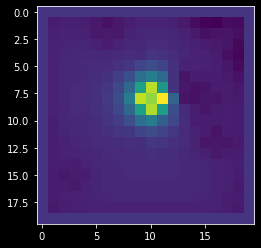

0 384.9


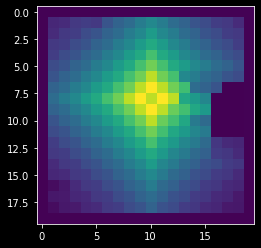

1 307.7


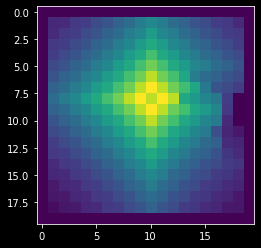

2 387.8


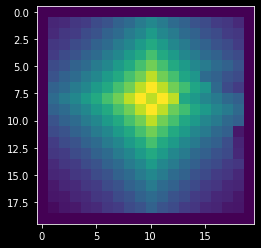

3 385.4


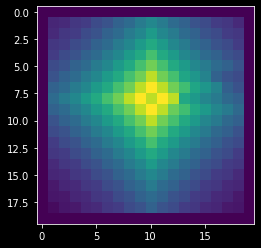

4 387.2


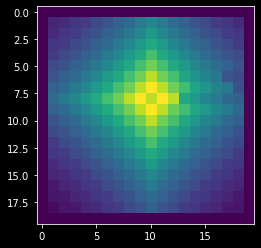

5 386.7


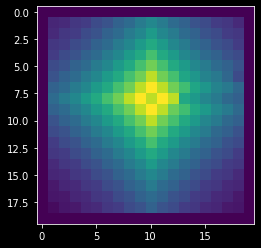

6 390.0


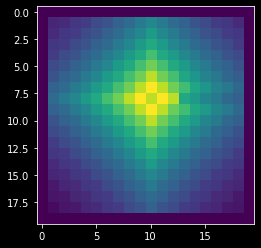

7 390.9


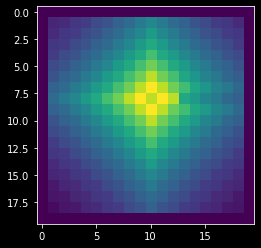

8 389.1


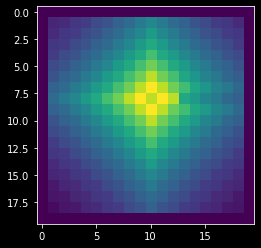

9 389.3


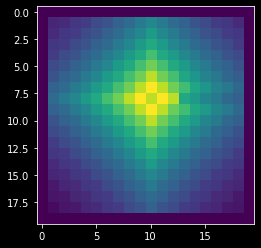

10 389.4


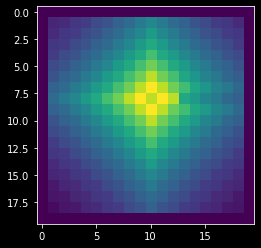

11 390.1


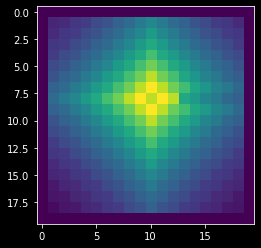

12 387.5


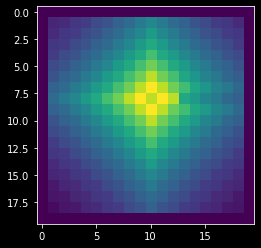

13 391.0


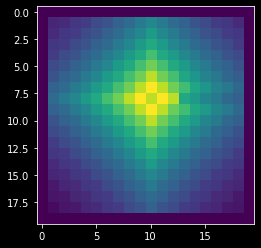

14 390.3


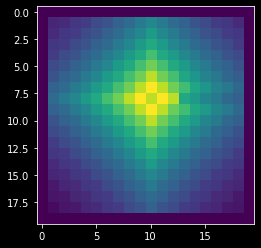

15 387.2


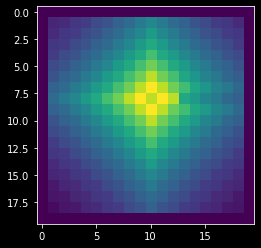

16 386.9


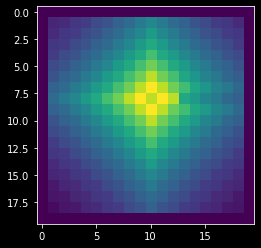

17 391.8


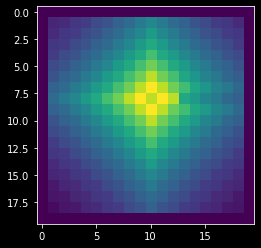

18 390.2


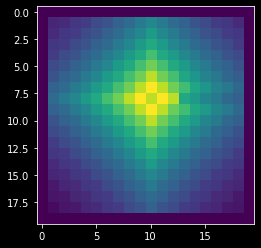

19 391.1


In [328]:
dungeon = DungeonDP(20)

gamma = 0.9
dungeon.display()
policy = Policy(dungeon, gamma)


for n_improvements in range(20):
    
    policy.policy_iteration(n_evaluations = 20)
    vals = policy.display_values()

    plt.imshow( (vals - vals.min())/(vals.max() - vals.min()) )
    plt.show()

    _, max_reward, mean_reward, var_reward = run_experiments(dungeon, policy, number_exp=10)
    
    print(n_improvements, mean_reward)
    

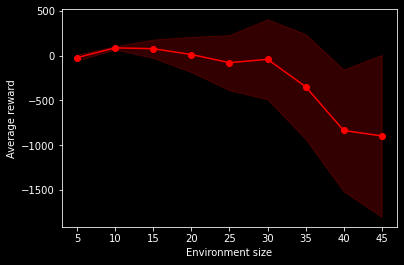

In [332]:
n_environments_per_size=5
n_runs_per_environments=5
gamma = 0.9

mean_reward = []
std_reward = []
    
for size_envir in range(5,50,5):

    # heuristics
    n_improvement_steps = size_envir
    n_steps_policy_eval = 10
    
    total_rewards = []

    for n_envir in range(n_environments_per_size):

        dungeon = DungeonDP(size_envir)
        policy = Policy(dungeon, gamma)
        
        for n_improvements in range(n_improvement_steps):
    
            policy.policy_iteration(n_steps_policy_eval)

        all_total_rewards, _, _, _ = run_experiments(dungeon, policy, n_runs_per_environments)

        total_rewards += all_total_rewards

    mean_reward.append( np.mean(total_rewards) )
    std_reward.append( np.std(total_rewards) )

mean_reward = np.asarray(mean_reward)
std_reward = np.asarray(std_reward)

plt.plot(range(5, 50, 5), mean_reward, 'or')
plt.plot(range(5, 50, 5), mean_reward, color = 'r')
plt.fill_between(range(5, 50, 5), mean_reward - std_reward/2, mean_reward + std_reward/2,
             color='r', alpha=0.2)

plt.xlabel('Environment size')
plt.ylabel('Average reward')

plt.show()